In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras import regularizers
import os

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/MyDrive/RawData"

'E.Anger.S10.angry V..WAV'	     saved_models
'E.Anger. S.10 .neutral V..WAV'     'Z.Anger.S10.angry V..WAV'
'E.Anger.S11.angry V..WAV'	    'Z.Anger. S10.neutral V.WAV'
'E.Anger. S.11 .neutral V..WAV'     'Z.Anger.S11.angry V..WAV'
'E.Anger.S12.angry V..WAV'	    'Z.Anger. S11.neutral V.WAV'
'E.Anger. S.12 .neutral V..WAV'     'Z.Anger.S12.angry V..WAV'
'E.Anger.S13.angry V..WAV'	    'Z.Anger. S12.neutral V.WAV'
'E.Anger. S.13 .neutral V..WAV'     'Z.Anger.S13.angry V..WAV'
'E.Anger.S14.angry V..WAV'	    'Z.Anger. S13.neutral V.WAV'
'E.Anger. S.14 .neutral V..WAV'     'Z.Anger.S14.angry V..WAV'
'E.Anger.S15.angry V..WAV'	    'Z.Anger. S14.neutral V.WAV'
'E.Anger. S.15 .neutral V..WAV'     'Z.Anger.S15.angry V..WAV'
'E.Anger.S16.angry V..WAV'	    'Z.Anger. S15.neutral V.WAV'
'E.Anger. S.16 .neutral V..WAV'     'Z.Anger.S16.angry V..WAV'
'E.Anger.S17.angry V..WAV'	    'Z.Anger. S16.neutral V.WAV'
'E.Anger. S.17 .neutral V..WAV'     'Z.Anger.S17.angry V..WAV'
'E.Anger.S1.angry V..WAV'	    '

In [6]:
mylist= os.listdir('/content/drive/MyDrive/RawData')
print(mylist)
print(len(mylist))

['E.Happiness.S10.happy V..WAV', 'E.Happiness.S9.happy V..WAV', 'E.Happiness.S8.happy V..WAV', 'Z.Anger.S15.angry V..WAV', 'Z.Anger.S1.angry V..WAV', 'Z.Anger.S14.angry V..WAV', 'Z.Anger.S10.angry V..WAV', 'Z.Anger.S12.angry V..WAV', 'Z.Anger.S17.angry V..WAV', 'Z.Anger.S13.angry V..WAV', 'Z.Anger.S11.angry V..WAV', 'Z.Anger.S16.angry V..WAV', 'Z.Disgust.S1.disgusting V..WAV', 'Z.Anger.S4.angry V..WAV', 'Z.Anger.S6.angry V..WAV', 'Z.Anger.S2.angry V..WAV', 'Z.Disgust.S10.disgusting V..WAV', 'Z.Anger.S7.angry V..WAV', 'Z.Anger.S5.angry V..WAV', 'Z.Anger.S9.angry V..WAV', 'Z.Anger.S8.angry V..WAV', 'Z.Anger.S3.angry V..WAV', 'Z.Disgust.S4.disgusting V..WAV', 'Z.Disgust.S6.disgusting V..WAV', 'Z.Disgust.S2.disgusting V..WAV', 'Z.Disgust.S14.disgusting V..WAV', 'Z.Disgust.S11.disgusting V..WAV', 'Z.Disgust.S13.disgusting V..WAV', 'Z.Disgust.S5.disgusting V..WAV', 'Z.Disgust.S3.disgusting V..WAV', 'Z.Disgust.S12.disgusting V..WAV', 'Z.Disgust.S15.disgusting V..WAV', 'Z.Fear.S1.frightened V.

In [7]:
rmdir /content/drive/MyDrive/RawData/.ipynb_checkpoints

rmdir: failed to remove '/content/drive/MyDrive/RawData/.ipynb_checkpoints': No such file or directory


In [8]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/RawData/Z.Sadness.S14.neutral V..WAV')

Populating the interactive namespace from numpy and matplotlib


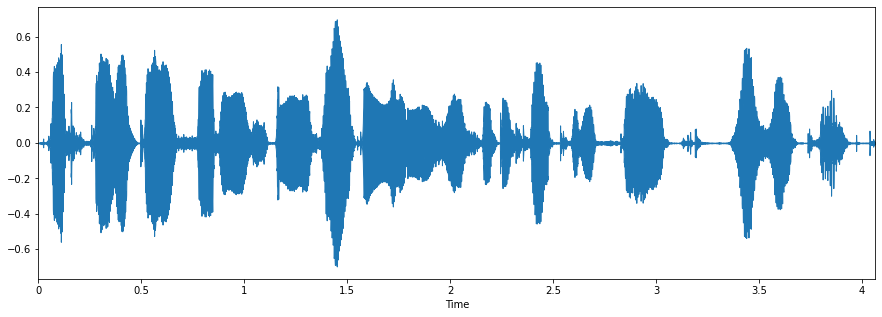

In [9]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

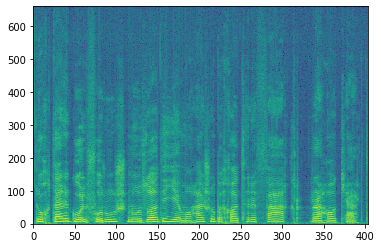

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/RawData/Z.Sadness.S14.neutral V..WAV')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [11]:
emotion_list = []
gender_list  = []
feeling_list =[]
for item in mylist:
  item = item.strip()
  #print(item)
  if item != 'saved_models' and item != 'model.json' and item != 'Predictions.csv':
    if item.split('.')[1] == 'Neutral':
      feelings = (item.split('.')[3].split(' ')[0])
      if feelings =='angry':
        feelings = 'Anger'
      elif feelings =='disgusting':
        feelings = 'Disgust'
      elif feelings =='frightened':
        feelings = 'Fear'
      elif feelings =='happy':
        feelings = 'Happiness'
      elif feelings =='sad':
        feelings = 'Sadness'
      elif feelings =='neutral':
        feelings = 'Neutal'
    else:
      feelings = (item.split('.')[1])
    
    gender = (item.split('.')[0])
    if gender =='Z':
      feeling_list.append('female_'+feelings.strip())
    elif gender == 'E':
      feeling_list.append('male_'+feelings.strip())
      

res = []
for i in feeling_list:
    if i not in res:
        res.append(i)

print(res)
print(len(res))

['male_Happiness', 'female_Anger', 'female_Disgust', 'female_Fear', 'female_Happiness', 'female_Sadness', 'male_Anger', 'male_Disgust', 'male_Fear', 'female_Neutal', 'male_Neutal', 'male_Sadness']
12


#Label Definition For All Rows

In [12]:
import pandas as pd
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:100]

,0
0,male_Happiness
1,male_Happiness
2,male_Happiness
3,female_Anger
4,female_Anger
...,...
95,male_Anger
96,male_Anger
97,male_Disgust
98,male_Disgust


In [14]:
print(mylist)

['E.Happiness.S10.happy V..WAV', 'E.Happiness.S9.happy V..WAV', 'E.Happiness.S8.happy V..WAV', 'Z.Anger.S15.angry V..WAV', 'Z.Anger.S1.angry V..WAV', 'Z.Anger.S14.angry V..WAV', 'Z.Anger.S10.angry V..WAV', 'Z.Anger.S12.angry V..WAV', 'Z.Anger.S17.angry V..WAV', 'Z.Anger.S13.angry V..WAV', 'Z.Anger.S11.angry V..WAV', 'Z.Anger.S16.angry V..WAV', 'Z.Disgust.S1.disgusting V..WAV', 'Z.Anger.S4.angry V..WAV', 'Z.Anger.S6.angry V..WAV', 'Z.Anger.S2.angry V..WAV', 'Z.Disgust.S10.disgusting V..WAV', 'Z.Anger.S7.angry V..WAV', 'Z.Anger.S5.angry V..WAV', 'Z.Anger.S9.angry V..WAV', 'Z.Anger.S8.angry V..WAV', 'Z.Anger.S3.angry V..WAV', 'Z.Disgust.S4.disgusting V..WAV', 'Z.Disgust.S6.disgusting V..WAV', 'Z.Disgust.S2.disgusting V..WAV', 'Z.Disgust.S14.disgusting V..WAV', 'Z.Disgust.S11.disgusting V..WAV', 'Z.Disgust.S13.disgusting V..WAV', 'Z.Disgust.S5.disgusting V..WAV', 'Z.Disgust.S3.disgusting V..WAV', 'Z.Disgust.S12.disgusting V..WAV', 'Z.Disgust.S15.disgusting V..WAV', 'Z.Fear.S1.frightened V.

#Load Audios By Librosa

In [15]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
      if y != 'saved_models' and y != 'model.json' and y != 'Predictions.csv':
        #print(y)
        #print(index)
        X, sample_rate = librosa.load('/content/drive/MyDrive/RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=25),
                        axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1     

In [16]:
df[:180]

,feature
0,"[-4.861835, -5.8239827, -12.326768, -11.294906..."
1,"[-10.684166, -11.843734, -15.338816, -14.48155..."
2,"[-8.122744, -9.743518, -16.316343, -16.466293,..."
3,"[-3.982813, -6.1622257, -14.959393, -14.118588..."
4,"[-12.172541, -12.322263, -11.509617, -10.79403..."
...,...
175,"[-6.3931403, -8.51041, -11.8394985, -11.354914..."
176,"[-16.869364, -15.731963, -15.688765, -11.99359..."
177,"[-13.587743, -9.339981, -6.593404, -7.2829924,..."
178,"[-5.8337684, -7.437764, -11.646612, -12.055237..."


In [17]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [18]:
newdf = pd.concat([df3,labels], axis=1)
print(newdf)

           0          1          2    ...        214        215             0  
0    -4.861835  -5.823983 -12.326768  ... -18.031141 -16.408831  male_Happiness
1   -10.684166 -11.843734 -15.338816  ... -16.470306 -15.667506  male_Happiness
2    -8.122744  -9.743518 -16.316343  ... -13.968235 -13.745525  male_Happiness
3    -3.982813  -6.162226 -14.959393  ...  -9.336637  -5.950252    female_Anger
4   -12.172541 -12.322263 -11.509617  ... -11.623987  -8.586748    female_Anger
..         ...        ...        ...  ...        ...        ...             ...
467  -8.396163  -9.022840 -11.240122  ... -10.636827  -6.763556    male_Sadness
468  -1.235211  -3.084821  -7.886355  ... -11.440804  -9.080296    male_Sadness
469  -4.116305  -4.425370  -4.221673  ...  -3.141533  -1.493142    male_Sadness
470  -7.296317  -7.708128 -11.522160  ...  -9.283930  -7.207068    male_Sadness
471   1.181993  -0.155905  -6.041789  ...  -8.128382  -5.755762    male_Sadness

[472 rows x 217 columns]


In [19]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [20]:
rnewdf[:180 ]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
0,-4.861835,-5.823983,-12.326768,-11.294906,-11.323258,-12.443920,-11.735232,-11.523377,-12.057518,-13.396316,-13.479688,-13.273648,-14.147264,-14.908608,-14.820025,-16.419064,-14.807801,-14.843178,-16.774824,-16.087473,-16.664135,-17.899015,-18.608902,-19.314730,-20.437420,-19.752701,-20.058283,-21.396250,-15.908477,-15.459964,-18.439615,-15.953531,-14.456068,-15.314905,-16.201866,-15.305048,-16.985823,-17.119329,-16.688467,-14.977337,...,-13.471920,-14.986912,-16.031748,-15.715367,-14.490887,-14.999027,-14.598722,-14.058907,-14.341842,-14.271499,-13.832180,-11.975578,-11.856121,-12.299130,-11.458578,-11.474613,-11.944719,-12.866476,-14.501535,-15.102418,-16.418957,-16.933546,-17.596895,-18.224987,-15.952253,-15.933147,-17.201666,-18.178896,-17.778320,-17.413515,-18.287794,-16.473425,-15.419304,-15.990181,-17.399103,-16.680426,-16.836044,-18.031141,-16.408831,male_Happiness
1,-10.684166,-11.843734,-15.338816,-14.481556,-14.470215,-14.104366,-16.062864,-14.593566,-15.593524,-16.882034,-17.910954,-17.096590,-18.485085,-20.459517,-19.081511,-16.813536,-17.437511,-17.982044,-17.228867,-16.477070,-16.788204,-15.768098,-14.115493,-14.621853,-13.482780,-14.063110,-13.469961,-12.239240,-11.620403,-9.360137,-9.409181,-11.042135,-13.851331,-13.398358,-13.639147,-13.440316,-12.276302,-11.735767,-11.552737,-12.165209,...,-11.316307,-11.147669,-11.751681,-11.844107,-12.190570,-12.469807,-12.077723,-11.151189,-9.468274,-9.569991,-10.126991,-11.138363,-11.227087,-12.652449,-12.318009,-12.867161,-13.020780,-12.452234,-12.145297,-12.792397,-15.430131,-16.277025,-17.716188,-19.428581,-18.111906,-16.901043,-16.005116,-17.242586,-17.799099,-18.188528,-18.486702,-18.154995,-19.245632,-20.215038,-16.712393,-14.685564,-16.026558,-16.470306,-15.667506,male_Happiness
2,-8.122744,-9.743518,-16.316343,-16.466293,-17.533546,-17.671600,-18.053970,-17.839766,-18.119467,-16.162441,-14.995395,-14.227597,-13.604486,-15.098422,-16.732546,-16.854263,-16.689009,-15.096772,-14.938743,-15.284580,-15.171072,-16.100660,-16.075504,-14.642726,-14.574963,-16.504816,-17.805056,-16.188606,-15.769890,-14.942527,-14.938934,-14.270688,-14.162293,-14.159482,-15.215774,-15.016460,-13.415646,-13.458622,-15.153263,-13.552786,...,-16.122536,-18.788071,-18.590933,-16.800362,-17.451471,-16.794584,-14.174170,-11.091146,-11.607927,-12.624019,-12.672812,-14.901983,-13.879395,-13.281590,-12.902328,-13.798202,-13.393943,-13.569156,-15.093262,-15.460397,-14.589165,-14.308983,-14.655194,-14.229975,-14.912877,-14.759802,-15.307792,-15.138651,-15.304004,-15.741646,-17.519234,-18.583668,-19.429924,-19.776793,-17.107185,-16.166193,-15.174400,-13.968235,-13.745525,male_Happiness
3,-3.982813,-6.162226,-14.959393,-14.118588,-13.790994,-14.474723,-14.913671,-14.595647,-14.380214,-15.304072,-15.862389,-17.837139,-17.480141,-17.883646,-20.009621,-18.339619,-18.060005,-19.784216,-19.609604,-18.790985,-17.568186,-16.740715,-18.238335,-18.682810,-19.151932,-20.076771,-20.195747,-19.956398,-19.700909,-15.450322,-14.331952,-14.358316,-13.534970,-12.434078,-11.893927,-12.535846,-12.808943,-12.546020,-12.615066,-13.093374,...,-20.513531,-19.843983,-20.468464,-20.232786,-17.561640,-16.889713,-16.325249,-17.228855,-17.874157,-16.525698,-14.647228,-7.310830,-5.700498,-8.164844,-11.003402,-12.150880,-14.218738,-14.208879,-13.136619,-12.202934,-12.574228,-13.034717,-13.261378,-13.781799,-14.827728,-16.515009,-16.198393,-14.853516,-14.867620,-14.460125,-15.628465,-14.521544,-12.693326,-9.656308,-8.753460,-12.050200,-12.818564,-9.336637,-5.950252,female_Anger
4,-12.172541,-12.322263,-11.509617,-10.794032,-12.059412,-10.701049,-12.453289,-15.018066,-15.112271,-14.568770,-12.121596,-8.924588,-9.164117,-11.839904,-12.059728,-11.004644,-11.126024

In [21]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:180]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
397,-0.814404,-2.571465,-9.811422,-8.426999,-8.746495,-11.196686,-12.643624,-13.002895,-13.549290,-14.944649,-15.842013,-14.287234,-13.639752,-14.201581,-12.292828,-10.688469,-10.084009,-9.901319,-10.418622,-11.155282,-12.586329,-12.333443,-11.643889,-9.382550,-7.590704,-6.603133,-5.379759,-5.838694,-7.682212,-8.981913,-10.854779,-10.859289,-9.393826,-10.856529,-11.347337,-11.831073,-12.792324,-12.412948,-12.443548,-11.606795,...,-15.523979,-12.957676,-12.266662,-12.569052,-11.945513,-12.705343,-11.896002,-10.299938,-10.126322,-9.422919,-10.407310,-10.617009,-11.029160,-14.640647,-15.273896,-16.560455,-16.405350,-16.788944,-15.761289,-14.435369,-15.527927,-14.978472,-13.062780,-12.567441,-12.720918,-11.941144,-12.583539,-10.566041,-9.831827,-10.384302,-9.697556,-9.491275,-9.944476,-8.884401,-9.383297,-9.486257,-8.638638,-6.734294,-3.375621,female_Sadness
265,-1.019274,-2.170912,-2.881312,-3.002908,-3.008521,-2.977030,-2.632874,-2.646074,-2.657546,-2.547039,-2.484870,-2.748358,-2.560493,-2.272168,-2.193999,-2.603784,-2.945096,-2.687438,-1.962498,-2.180691,-2.999211,-3.865982,-4.225557,-4.833685,-5.894326,-6.801706,-7.139117,-8.879972,-9.323740,-7.795438,-5.015791,-2.424699,-1.838991,-2.806956,-2.136752,-2.071828,-1.964538,-1.623240,-1.497360,-1.550431,...,-6.842566,-5.917509,-5.304142,-5.031059,-5.213063,-5.525353,-5.216692,-6.844101,-9.062953,-8.926319,-10.143435,-10.558891,-9.535300,-9.649730,-10.156048,-9.566924,-6.924101,-4.689188,-3.331952,-3.361085,-3.101263,-3.352514,-2.889952,-2.689872,-2.602635,-2.527286,-2.260898,-1.970949,-2.466867,-3.230968,-4.671759,-5.975865,-6.495607,-7.645220,-7.971139,-6.679837,-5.694316,-4.702464,-3.917135,male_Fear
4,-12.172541,-12.322263,-11.509617,-10.794032,-12.059412,-10.701049,-12.453289,-15.018066,-15.112271,-14.568770,-12.121596,-8.924588,-9.164117,-11.839904,-12.059728,-11.004644,-11.126024,-13.236567,-14.112672,-12.141920,-11.324464,-12.847953,-12.145047,-13.064902,-16.577156,-16.868717,-16.100235,-14.596048,-15.322955,-15.630658,-15.604520,-16.980816,-15.919376,-14.198062,-12.469382,-11.858079,-13.004463,-14.222716,-16.678436,-17.823746,...,-17.777050,-18.735027,-19.411484,-16.611401,-15.077623,-16.108494,-15.762079,-16.807581,-16.360428,-15.532969,-13.980547,-12.402196,-11.888841,-13.822252,-15.323191,-14.368965,-13.529580,-12.034114,-10.297503,-10.611353,-14.031434,-17.166649,-16.299999,-14.470066,-11.543894,-11.586675,-13.028921,-15.428990,-16.099060,-17.034981,-17.061646,-16.292723,-13.108791,-8.949922,-8.315701,-10.436402,-11.646160,-11.623987,-8.586748,female_Anger
416,-6.908676,-7.341092,-8.592823,-9.171209,-8.351628,-8.650516,-9.842871,-9.755091,-9.476113,-8.921798,-8.349189,-6.739769,-6.784050,-6.705725,-6.461287,-7.638489,-6.945007,-7.545915,-8.149117,-9.715994,-10.112938,-9.539683,-9.883403,-10.734455,-11.450522,-11.269486,-10.498580,-9.833992,-10.577076,-11.889366,-12.180195,-12.614488,-12.288347,-11.233109,-11.206670,-12.249751,-12.002100,-11.401896,-11.342791,-11.350686,...,-9.338227,-9.459417,-8.835974,-7.955473,-8.465908,-8.607998,-8.019443,-7.200913,-7.171171,-8.178183,-8.479483,-8.082183,-7.468603,-7.381229,-6.640198,-5.670740,-6.429997,-7.360948,-8.125454,-8.249042,-8.773600,-9.504555,-9.052587,-9.562808,-10.429452,-11.047208,-10.760611,-10.895638,-10.991934,-12.091949,-11.542624,-11.416077,-11.611802,-11.656641,-10.467295,-10.156408,-13.139465,-11.102719,-9.003695,male_Disgust
366,-4.103644,-5.846854,-11.789311,-14.288076,-11.407959,-10.109696,-12.869647,-15.986556,-16.967012,-16.843084,-15.738733,-14.922311,-13.943173,-14.977858,-14.231088,-12.504107,-11.878750,-12.531532,-13.225142,-12.155978,-11.325089,-10.193735,-11.229347,-11.010530,-9.843259,-9.819840,-11.686535,-13.148401,-13.836740,-14.4

In [22]:
rnewdf=rnewdf.fillna(0)

In [23]:
rnewdf.shape

(472, 217)

#Dividing the data into test and train

In [46]:
newdf1 = np.random.rand(len(rnewdf)) < 0.90
train = rnewdf[newdf1]
test = rnewdf[~newdf1]
print(train.shape)
print('---------------------')
print(test.shape)
print('---------------------')
train
print('---------------------')
test

(416, 217)
---------------------
(56, 217)
---------------------
---------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
192,-4.526396,-6.153525,-10.535536,-10.743963,-9.428823,-9.898044,-9.436331,-9.691754,-11.261968,-12.032307,-12.815965,-12.220044,-11.504838,-12.225145,-12.859506,-12.604382,-12.291150,-13.600363,-13.669053,-13.324524,-12.617435,-11.697371,-9.842517,-8.752426,-7.665946,-7.022184,-7.231641,-9.397581,-12.814777,-12.549915,-10.958235,-8.159102,-6.942809,-7.668726,-7.719049,-7.621334,-8.384620,-11.038024,-10.065222,-10.268932,...,-10.505899,-9.290768,-10.153075,-11.882921,-10.185005,-9.463346,-9.698548,-8.964397,-10.592966,-10.308380,-10.690896,-12.300846,-12.558806,-12.431263,-14.090316,-12.777086,-12.073694,-12.512623,-12.139657,-11.637984,-11.720661,-12.204847,-11.891863,-12.095456,-10.471959,-11.130829,-10.992435,-11.106235,-10.214917,-9.762239,-10.415802,-13.366337,-13.704885,-11.931454,-11.504226,-8.954911,-7.613140,-7.824264,-8.863148,female_Neutal
369,-1.489822,-3.128242,-11.321084,-12.630867,-13.245541,-12.292011,-13.194070,-15.575625,-17.475286,-15.825675,-15.342189,-14.977743,-14.593040,-13.857592,-12.601026,-9.623260,-8.945874,-9.668670,-10.228063,-12.233215,-13.572002,-13.764174,-14.405256,-15.860817,-16.245674,-18.649439,-19.405279,-19.038647,-20.450607,-22.565201,-20.995750,-20.055164,-15.949055,-14.159006,-14.341135,-13.457370,-12.936848,-11.866943,-12.635180,-13.250040,...,-12.574867,-17.102123,-18.561737,-15.288872,-14.624982,-15.997454,-16.605631,-16.961628,-16.268431,-15.339252,-14.858224,-14.598686,-16.026161,-16.951401,-15.735172,-15.647726,-17.720211,-17.294670,-17.025393,-16.111088,-16.296223,-15.867803,-14.183799,-15.321036,-14.887647,-13.722203,-12.763999,-14.088040,-13.521592,-7.535577,-6.830324,-9.246631,-11.619567,-12.061666,-14.392651,-13.602423,-12.906216,-6.776970,-3.410959,female_Fear
166,-2.606209,-4.652375,-9.364279,-9.683788,-10.652005,-10.702566,-11.699863,-11.915835,-12.016587,-12.389448,-11.860713,-11.237114,-10.332539,-11.004709,-10.940335,-10.382595,-9.814083,-9.070094,-9.778626,-9.453353,-9.950697,-10.142272,-10.368577,-12.580924,-12.149083,-14.082411,-12.404030,-9.657214,-9.667636,-10.743512,-11.776453,-12.585100,-14.325316,-14.383344,-13.807439,-12.033777,-13.735701,-13.826023,-15.015480,-16.557482,...,-4.916812,-5.992534,-7.685803,-8.827422,-8.353507,-6.078741,-6.544405,-9.100216,-10.003902,-8.900638,-7.920839,-8.549858,-8.412210,-8.355633,-9.298556,-8.839023,-9.233204,-9.050931,-8.963151,-7.555720,-8.523243,-8.284513,-7.851098,-8.725819,-7.737210,-9.479025,-13.075554,-13.940274,-14.616572,-14.948639,-10.276081,-9.950557,-9.677866,-8.957937,-9.796545,-10.241956,-9.257598,-5.617842,-1.951642,female_Fear
279,-3.941556,-4.350909,-5.529985,-5.579038,-6.045744,-5.126325,-4.643639,-3.943136,-3.893465,-4.018915,-4.155445,-4.745002,-5.360132,-5.344652,-5.394429,-5.493392,-5.174730,-4.888716,-4.536895,-3.987875,-3.553255,-3.271068,-3.972838,-5.818677,-7.008999,-6.999498,-6.054882,-5.193590,-5.155912,-5.005474,-4.771027,-4.201684,-3.569144,-3.282872,-3.182820,-3.431907,-3.534366,-3.678781,-3.926030,-4.190763,...,-6.308138,-5.697190,-5.411841,-5.191230,-4.714324,-4.562830,-4.576934,-4.551375,-4.472838,-4.309049,-4.201684,-3.877255,-3.905001,-3.939189,-3.860996,-5.077902,-6.209133,-7.352686,-7.385651,-6.981513,-7.757660,-8.912793,-9.526405,-9.260254,-6.762927,-5.331781,-4.210201,-4.652603,-4.344195,-4.448137,-4.681813,-4.905800,-5.958113,-6.719664,-7.788537,-7.376137,-5.947080,-4.128067,-3.395624,male_Happiness
20,-2.341891,-3.859399,-11.366869,-11.421582,-11.929239,-13.660409,-14.339709,-12.993726,-12.772948,-13.322931,-14.470324,-14.869676,-14.597775,-16.518290,-12.566509,-10.582832,-10.760163,-11.476554,-10.615717,-9.573180,-10.530104,-12.024123,-13.061282,-14.443751,-14.520289,-13.088100,-11.985069,-12.147440,-13.369329,-13.81

In [47]:
train[:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
397,-0.814404,-2.571465,-9.811422,-8.426999,-8.746495,-11.196686,-12.643624,-13.002895,-13.549290,-14.944649,-15.842013,-14.287234,-13.639752,-14.201581,-12.292828,-10.688469,-10.084009,-9.901319,-10.418622,-11.155282,-12.586329,-12.333443,-11.643889,-9.382550,-7.590704,-6.603133,-5.379759,-5.838694,-7.682212,-8.981913,-10.854779,-10.859289,-9.393826,-10.856529,-11.347337,-11.831073,-12.792324,-12.412948,-12.443548,-11.606795,...,-15.523979,-12.957676,-12.266662,-12.569052,-11.945513,-12.705343,-11.896002,-10.299938,-10.126322,-9.422919,-10.407310,-10.617009,-11.029160,-14.640647,-15.273896,-16.560455,-16.405350,-16.788944,-15.761289,-14.435369,-15.527927,-14.978472,-13.062780,-12.567441,-12.720918,-11.941144,-12.583539,-10.566041,-9.831827,-10.384302,-9.697556,-9.491275,-9.944476,-8.884401,-9.383297,-9.486257,-8.638638,-6.734294,-3.375621,female_Sadness
265,-1.019274,-2.170912,-2.881312,-3.002908,-3.008521,-2.977030,-2.632874,-2.646074,-2.657546,-2.547039,-2.484870,-2.748358,-2.560493,-2.272168,-2.193999,-2.603784,-2.945096,-2.687438,-1.962498,-2.180691,-2.999211,-3.865982,-4.225557,-4.833685,-5.894326,-6.801706,-7.139117,-8.879972,-9.323740,-7.795438,-5.015791,-2.424699,-1.838991,-2.806956,-2.136752,-2.071828,-1.964538,-1.623240,-1.497360,-1.550431,...,-6.842566,-5.917509,-5.304142,-5.031059,-5.213063,-5.525353,-5.216692,-6.844101,-9.062953,-8.926319,-10.143435,-10.558891,-9.535300,-9.649730,-10.156048,-9.566924,-6.924101,-4.689188,-3.331952,-3.361085,-3.101263,-3.352514,-2.889952,-2.689872,-2.602635,-2.527286,-2.260898,-1.970949,-2.466867,-3.230968,-4.671759,-5.975865,-6.495607,-7.645220,-7.971139,-6.679837,-5.694316,-4.702464,-3.917135,male_Fear
4,-12.172541,-12.322263,-11.509617,-10.794032,-12.059412,-10.701049,-12.453289,-15.018066,-15.112271,-14.568770,-12.121596,-8.924588,-9.164117,-11.839904,-12.059728,-11.004644,-11.126024,-13.236567,-14.112672,-12.141920,-11.324464,-12.847953,-12.145047,-13.064902,-16.577156,-16.868717,-16.100235,-14.596048,-15.322955,-15.630658,-15.604520,-16.980816,-15.919376,-14.198062,-12.469382,-11.858079,-13.004463,-14.222716,-16.678436,-17.823746,...,-17.777050,-18.735027,-19.411484,-16.611401,-15.077623,-16.108494,-15.762079,-16.807581,-16.360428,-15.532969,-13.980547,-12.402196,-11.888841,-13.822252,-15.323191,-14.368965,-13.529580,-12.034114,-10.297503,-10.611353,-14.031434,-17.166649,-16.299999,-14.470066,-11.543894,-11.586675,-13.028921,-15.428990,-16.099060,-17.034981,-17.061646,-16.292723,-13.108791,-8.949922,-8.315701,-10.436402,-11.646160,-11.623987,-8.586748,female_Anger
416,-6.908676,-7.341092,-8.592823,-9.171209,-8.351628,-8.650516,-9.842871,-9.755091,-9.476113,-8.921798,-8.349189,-6.739769,-6.784050,-6.705725,-6.461287,-7.638489,-6.945007,-7.545915,-8.149117,-9.715994,-10.112938,-9.539683,-9.883403,-10.734455,-11.450522,-11.269486,-10.498580,-9.833992,-10.577076,-11.889366,-12.180195,-12.614488,-12.288347,-11.233109,-11.206670,-12.249751,-12.002100,-11.401896,-11.342791,-11.350686,...,-9.338227,-9.459417,-8.835974,-7.955473,-8.465908,-8.607998,-8.019443,-7.200913,-7.171171,-8.178183,-8.479483,-8.082183,-7.468603,-7.381229,-6.640198,-5.670740,-6.429997,-7.360948,-8.125454,-8.249042,-8.773600,-9.504555,-9.052587,-9.562808,-10.429452,-11.047208,-10.760611,-10.895638,-10.991934,-12.091949,-11.542624,-11.416077,-11.611802,-11.656641,-10.467295,-10.156408,-13.139465,-11.102719,-9.003695,male_Disgust
366,-4.103644,-5.846854,-11.789311,-14.288076,-11.407959,-10.109696,-12.869647,-15.986556,-16.967012,-16.843084,-15.738733,-14.922311,-13.943173,-14.977858,-14.231088,-12.504107,-11.878750,-12.531532,-13.225142,-12.155978,-11.325089,-10.193735,-11.229347,-11.010530,-9.843259,-9.819840,-11.686535,-13.148401,-13.836740,-14.4

In [48]:
trainfeatures = train.iloc[:, :-1]

In [49]:
trainlabel = train.iloc[:, -1:]

In [50]:
testfeatures = test.iloc[:, :-1]

In [51]:
testlabel = test.iloc[:, -1:]

In [52]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
X_train.shape

(416, 216)

In [54]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [55]:
y_test

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.,

In [56]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
X_train.shape

(416, 216)

In [58]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

#Final

In [62]:
from tensorflow.keras import optimizers
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(12))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

#Final Model

In [50]:
model = Sequential()
model.add(Dense(512,  input_shape=(216,14), kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))       

model.add(Dense(12, activation ='softmax'))

In [63]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [65]:
cnnhistory =model.fit(x_traincnn ,y_train ,  
          batch_size = 1500,
          epochs = 1500,
          verbose = 1,
          validation_data =(x_testcnn, y_test)
          )

Epoch 1/1500
1/1 [==============================] - 0s 162ms/step - loss: 0.3737 - accuracy: 0.8654 - val_loss: 2.0244 - val_accuracy: 0.4107
Epoch 2/1500
1/1 [==============================] - 0s 128ms/step - loss: 0.3472 - accuracy: 0.8822 - val_loss: 2.0479 - val_accuracy: 0.4286
Epoch 3/1500
1/1 [==============================] - 0s 120ms/step - loss: 0.3872 - accuracy: 0.8654 - val_loss: 1.9549 - val_accuracy: 0.4464
Epoch 4/1500
1/1 [==============================] - 0s 117ms/step - loss: 0.3879 - accuracy: 0.8606 - val_loss: 2.3997 - val_accuracy: 0.3571
Epoch 5/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.4312 - accuracy: 0.8389 - val_loss: 1.8033 - val_accuracy: 0.4286
Epoch 6/1500
1/1 [==============================] - 0s 122ms/step - loss: 0.6910 - accuracy: 0.7668 - val_loss: 2.6289 - val_accuracy: 0.2679
Epoch 7/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.7623 - accuracy: 0.7356 - val_loss: 1.7317 - val_accuracy: 0.4464
Epoch 

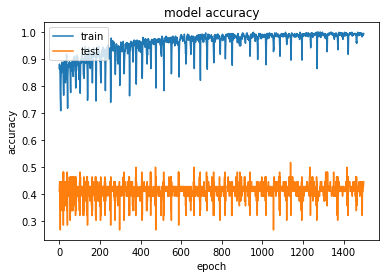

In [104]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/RawData/saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/RawData/saved_models/Emotion_Voice_Detection_Model.h5 


In [67]:
import json
model_json = model.to_json()
with open("/content/drive/MyDrive/RawData/model.json", "w") as json_file:
    json_file.write(model_json)

#Prediction Accuracy For Test Set

In [68]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/RawData/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/RawData/saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 44.64%


In [69]:
preds = model.predict(x_testcnn)
preds

array([[9.87833664e-02, 8.48094448e-02, 2.98016012e-01, 1.35072172e-01,
        8.43995064e-02, 2.53150165e-01, 2.02727460e-05, 2.98439781e-03,
        3.78293581e-02, 4.73908987e-03, 1.06220541e-05, 1.85598765e-04],
       [7.78927654e-02, 1.98365119e-03, 6.74108624e-01, 2.96317856e-03,
        1.30478099e-06, 2.20598742e-01, 7.86855807e-08, 8.14268060e-06,
        2.24260036e-02, 1.30292901e-05, 4.41147586e-06, 3.53865062e-08],
       [4.32538707e-03, 1.18393589e-04, 2.48326346e-01, 3.03074196e-02,
        7.62476772e-03, 5.99838197e-02, 3.31639079e-04, 6.01131022e-02,
        5.87151527e-01, 2.85069866e-04, 2.71463341e-05, 1.40543515e-03],
       [7.48509847e-05, 6.28998805e-07, 1.80803631e-02, 3.68787162e-03,
        1.16345262e-04, 9.48320394e-06, 5.85400230e-05, 1.19541464e-02,
        9.64390934e-01, 1.46906404e-03, 1.37994994e-06, 1.56488604e-04],
       [7.85291672e-01, 3.57931247e-04, 8.17410722e-02, 4.92605492e-02,
        2.77971048e-02, 5.36933169e-02, 4.27751183e-05, 4.96

In [70]:
preds1=preds.argmax(axis=1)

In [71]:
preds1

array([ 2,  2,  8,  8,  0,  8,  8,  0,  6,  1,  9, 10,  1,  2,  2,  6,  5,
        2,  9,  0,  6,  2,  3,  7,  8,  2,  0,  7, 11,  8,  8, 11,  6,  7,
        8,  1,  2,  8,  8,  5,  2, 11,  8,  8,  0,  5,  0,  8,  2, 10,  2,
        1,  8,  9,  2, 11])

In [72]:
abc = preds1.astype(int).flatten()
print(abc)

[ 2  2  8  8  0  8  8  0  6  1  9 10  1  2  2  6  5  2  9  0  6  2  3  7
  8  2  0  7 11  8  8 11  6  7  8  1  2  8  8  5  2 11  8  8  0  5  0  8
  2 10  2  1  8  9  2 11]


In [73]:
predictions = (lb.inverse_transform(abc))

In [74]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_Fear
1,female_Fear
2,male_Fear
3,male_Fear
4,female_Anger
5,male_Fear
6,male_Fear
7,female_Anger
8,male_Anger
9,female_Disgust


In [75]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [76]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_Neutal
1,female_Fear
2,female_Fear
3,male_Happiness
4,female_Anger
5,male_Sadness
6,male_Fear
7,female_Sadness
8,male_Anger
9,female_Neutal


In [77]:
finaldf = actualdf.join(preddf)

In [78]:
finaldf[:10]

,actualvalues,predictedvalues
0,female_Neutal,female_Fear
1,female_Fear,female_Fear
2,female_Fear,male_Fear
3,male_Happiness,male_Fear
4,female_Anger,female_Anger
5,male_Sadness,male_Fear
6,male_Fear,male_Fear
7,female_Sadness,female_Anger
8,male_Anger,male_Anger
9,female_Neutal,female_Disgust


In [79]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_Anger,3
female_Disgust,2
female_Fear,9
female_Happiness,6
female_Neutal,4
female_Sadness,2
male_Anger,3
male_Disgust,4
male_Fear,5


In [80]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_Anger,6
female_Disgust,4
female_Fear,12
female_Happiness,1
female_Sadness,3
male_Anger,4
male_Disgust,3
male_Fear,14
male_Happiness,3


In [81]:
finaldf.to_csv('Predictions.csv', index=False)

In [82]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/RawData/ Z.Disgust. S10 .neutral V.WAV')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


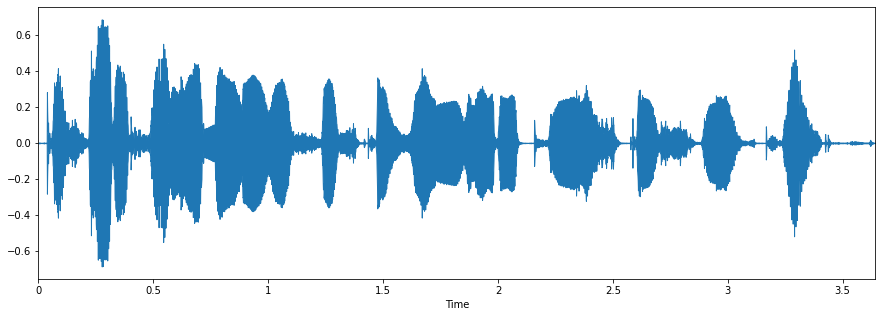

In [83]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [94]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('/content/drive/MyDrive/RawData/E. Fear. S.2 .neutr.al V..WAV', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [95]:
livedf2= pd.DataFrame(data=livedf2)

In [96]:
livedf2 = livedf2.stack().to_frame().T

In [97]:
livedf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-1.987352,-1.752961,-2.268858,-2.25493,-2.405952,-4.38345,-7.104653,-9.493784,-10.194005,-7.334443,-9.270731,-11.657602,-12.642629,-6.830566,-3.376098,-1.578035,-0.904396,-0.911742,-1.55159,-2.09621,-2.873931,-4.276927,-5.944738,-7.727101,-8.748159,-9.006456,-8.747611,-7.676318,-6.471182,-5.179492,-3.968164,-3.689511,-3.112429,-2.568606,-2.170976,-1.950686,-2.469735,-2.946497,-4.033008,-4.703519,...,-4.336272,-4.563752,-5.287594,-5.783038,-5.304605,-4.66951,-4.645943,-4.875127,-4.067285,-5.692492,-6.110921,-7.196807,-9.713461,-11.473738,-14.695648,-20.710918,-26.02364,-29.011087,-30.293901,-31.53751,-19.708218,-8.785491,-6.305948,-4.779399,-3.280789,-2.165056,-1.173964,-1.235662,-1.900574,-3.123671,-4.482127,-5.604989,-8.828561,-11.968414,-14.290521,-15.094191,-16.44562,-18.539631,-21.430227,-23.786131


In [98]:
twodim= np.expand_dims(livedf2, axis=2)

In [99]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 17ms/step


In [100]:
livepreds

array([[7.8058477e-25, 6.3717460e-26, 3.9447836e-16, 3.2715989e-17,
        5.0238228e-26, 6.1891495e-34, 1.3221494e-15, 6.3943906e-11,
        1.0000000e+00, 5.8867113e-11, 8.2871573e-13, 1.6625409e-14]],
      dtype=float32)

In [101]:
livepreds1=livepreds.argmax(axis=1)

In [102]:
liveabc = livepreds1.astype(int).flatten()

In [103]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_Fear'], dtype=object)